<a href="https://colab.research.google.com/github/tsshubhamv/stylegan2-ada-pytorch/blob/main/correct_kit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Software

Some software must be installed into Colab, for this notebook to work. We are specificially using these technologies:

* [Training Generative Adversarial Networks with Limited Data](https://arxiv.org/abs/2006.06676)
Tero Karras, Miika Aittala, Janne Hellsten, Samuli Laine, Jaakko Lehtinen, Timo Aila
* [One millisecond face alignment with an ensemble of regression trees](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf) Vahid Kazemi, Josephine Sullivan


In [1]:
import os
import sys
from google.colab import files
import torch

!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2
!git clone https://github.com/tsshubhamv/stylegan2-ada-pytorch.git
!pip install ninja
sys.path.insert(0, "/content/stylegan2-ada-pytorch")

import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import cv2
import numpy as np

def display_lowres(img):
  plt.imshow(img)
  plt.title('source-gan')
  plt.show()

def seed2vec(g, seed):
  return np.random.RandomState(seed).randn(1, g.z_dim)

def load_vec(filename):
  result = np.load(filename)
  return result if 'w' not in result else result['w']

def save_vec(filename, lvec):
  numpy.save(filename,lvec)

def to_image(img):
  return PIL.Image.fromarray(img, 'RGB')

def render_gan(G, device, lvec, label=None, truncation_psi=1, noise_mode='const'):
  # noise mode 'const', 'random', 'none'
  z = torch.from_numpy(lvec).to(device)
  if label is None: label = torch.zeros([1, G.c_dim], device=device)
  if len(lvec.shape) == 2:
    img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  else:
    img = G.synthesis(z, noise_mode=noise_mode)

  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

--2023-08-02 19:49:54--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2’

shape_predictor_5_f 100%[===================>]   5.44M  3.19MB/s    in 1.7s    

2023-08-02 19:49:56 (3.19 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2’ saved [5706710/5706710]

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 550, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 550 (delta 1), reused 1 (delta 0), pack-reused 544
Receiving objects: 100% (550/550), 9.00 MiB | 32.11 MiB/s, done.
Resolving deltas: 100% (309/309), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 1.8 MB/s eta 0:00:00


# Accessing Data

### Mount Google Drive (GDRIVE)

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


### Upload an Image


In [ ]:
import os
from google.colab import files

uploaded = files.upload()

for k, v in uploaded.items():
  _, ext = os.path.splitext(k)
  print(f"You uploaded /content/{k}")

Saving 1668505098383_20221115_143827@&@mouth_256x256.jpeg to 1668505098383_20221115_143827@&@mouth_256x256.jpeg
You uploaded /content/1668505098383_20221115_143827@&@mouth_256x256.jpeg


### Download Image or File

In [ ]:
from google.colab import files
files.download("/content/cropped-jeff.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load a Pretrained GAN

In [2]:
!gdown --id 10PPogDpfuoRUEC4NPUHi24wv--xodmTm

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10PPogDpfuoRUEC4NPUHi24wv--xodmTm
To: /content/sg2-ml-smile_256.pkl
100% 296M/296M [00:06<00:00, 47.4MB/s]


In [3]:
STYLEGAN2_PKL_URL = "/content/sg2-ml-smile_256.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-gan-70s-scifi/releases/download/v1/70s-scifi-gan-2020-12-12.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/download/v1/christmas-gan-2020-12-03.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-gan-minecraft/releases/download/v1/minecraft-gan-2020-12-22.pkl"

device = torch.device('cuda')
with dnnlib.util.open_url(STYLEGAN2_PKL_URL) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

# Generate GAN Images from Seeds

Generating image for seed 1000 (0/3) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


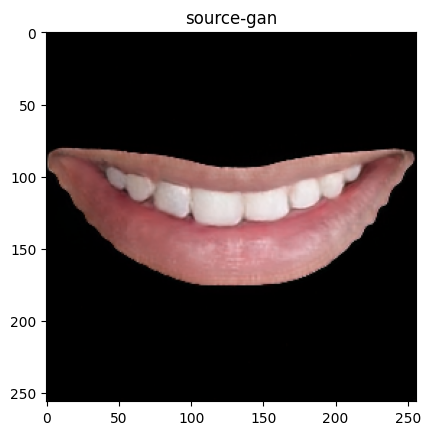

Generating image for seed 1001 (1/3) ...


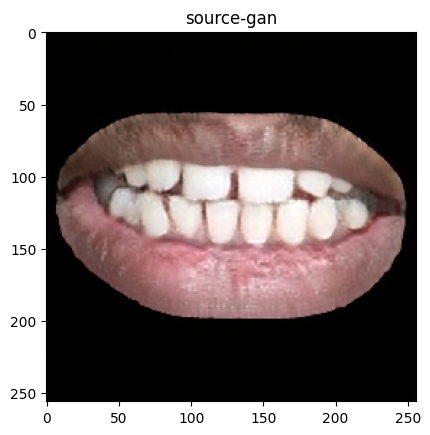

Generating image for seed 1002 (2/3) ...


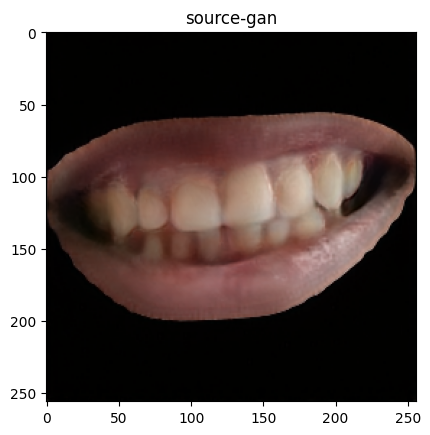

In [4]:
seeds = [1000,1001,1002]
OUTDIR = "/content/seeds"

# Create directory
try:
    os.makedirs(OUTDIR)
except OSError:
    pass

# Generate images.

for seed_idx, seed in enumerate(seeds):
  print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)))
  lv = seed2vec(G, seed)
  img = render_gan(G, device, lv)
  img.save(f'{OUTDIR}/seed{seed:04d}.png') # Save it
  #display(img2) # Display hi-res
  display_lowres(img)

## Load a Saved Latent Vector and Display

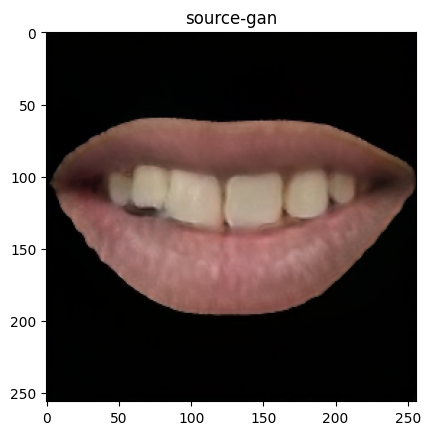

In [ ]:
lvec = load_vec('/content/jeff/projected_w.npz')
img = render_gan(G, device, lvec)
display_lowres(img)

In [8]:
!unzip test.zip -d data/

Archive:  test.zip
   creating: data/test/
   creating: data/test/5/
  inflating: data/test/5/1668076134391_IMG_20221110_155301@&@mouth_256x256.jpeg  
  inflating: data/test/5/1668076784279_IMG_20221110_160803@&@mouth_256x256.jpeg  
  inflating: data/test/5/1668090445626_7F03CC54_F026_4584_9C8F_7F399BABC4F4@&@mouth_256x256.jpeg  
  inflating: data/test/5/1668094676348_IMG_20221110_210210@&@mouth_256x256.jpeg  
  inflating: data/test/5/1668136230623_IMG_20221111_083530@&@mouth_256x256.jpeg  
  inflating: data/test/5/1668138991842_IMG_20221111_092618@&@mouth_256x256.jpeg  
  inflating: data/test/5/1668143559456_IMG_20221111_103920@&@mouth_256x256.jpeg  
  inflating: data/test/5/1668145492824_IMG_20221110_164546@&@mouth_256x256.jpeg  
  inflating: data/test/5/1668148834414_IMG_20221111_120613@&@mouth_256x256.jpeg  
  inflating: data/test/5/1668150300304_IMG_20221111_122750@&@mouth_256x256.jpeg  
  inflating: data/test/5/1668153330189_IMG_20221111_132147@&@mouth_256x256.jpeg  
  inflating:

# Convert Image to a GAN

First, we convert the source to a GAN latent vector.  This process will take several minutes.

In [9]:
STYLEGAN2_PKL_URL

'/content/sg2-ml-smile_256.pkl'

In [10]:
import os
images = []
folders = []
for idx, cur in enumerate(os.listdir("/content/data/test/7/")):
  images.append(f"/content/data/test/7/{cur}")
  folders.append(cur.replace(".jpeg", ""))
  os.makedirs("/content/output/" + cur.replace(".jpeg", ""), exist_ok=True)

In [12]:
images[:1]

['/content/data/test/7/1668515488859_IMG_20221115_175602@&@mouth_256x256.jpeg']

In [14]:
!cd /content/stylegan2-ada-pytorch/ && git pull

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 3), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (6/6), 502.79 KiB | 5.35 MiB/s, done.
From https://github.com/tsshubhamv/stylegan2-ada-pytorch
   9f809cf..196451a  main       -> origin/main
Updating 9f809cf..196451a
Fast-forward
 correct_kit.ipynb | 1885 ++++++++++++++++++++++++++++++++++-------------------
 projector.py      |    2 +-
 2 files changed, 1201 insertions(+), 686 deletions(-)


In [19]:
!cat /content/stylegan2-ada-pytorch/projector.py

# Copyright (c) 2021, NVIDIA CORPORATION.  All rights reserved.
#
# NVIDIA CORPORATION and its licensors retain all intellectual property
# and proprietary rights in and to this software, related documentation
# and any modifications thereto.  Any use, reproduction, disclosure or
# distribution of this software and related documentation without an express
# license agreement from NVIDIA CORPORATION is strictly prohibited.

"""Project given image to the latent space of pretrained network pickle."""

import copy
import os
from time import perf_counter

import click
import imageio
import numpy as np
import PIL.Image
import torch
import torch.nn.functional as F

# for scoreneti 
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

import dnnlib
import legacy

def project(
    G,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    num_steps                  = 1000,
    w

In [18]:
for idx, cur in enumerate(images[:1]):
  cur_folder = folders[idx]
  SOURCE_NAME = f"'{cur}'"
  OUT = "/content/jeff/"

  cmd = f"python /content/stylegan2-ada-pytorch/projector.py --seed 303 --save-video 1 --num-steps 300 --outdir={OUT} --target={SOURCE_NAME} --network={STYLEGAN2_PKL_URL}"
  !{cmd}

Loading networks from "/content/sg2-ml-smile_256.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %106 : int = prim::profile_ivalue(%104)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
step    1/300: dist 0.29 loss 24564.66
step    2/300: dist 0.30 loss 27637.98
step    3/300: dist 0.29 loss 26108.37
step    4/300: dist 0.31 loss 23376.40
step    5/300: dist 0.29 loss 19880.64
step    6/300: dist 0.33 loss 15972.88
step    7/300: dist 0.32 loss 12027.03
step    8/300: dist 0.25 loss 8421.71
step    9/300: dist 0.26 loss 5460.60
step   10/300: dist 0.23 loss 3415.78
step   11/300: dist 0.25 loss 2606.97
step   12/300: dist 0.19 loss 2898.75
step   13/300: dist

In [58]:
# Copyright (c) 2021, NVIDIA CORPORATION.  All rights reserved.
#
# NVIDIA CORPORATION and its licensors retain all intellectual property
# and proprietary rights in and to this software, related documentation
# and any modifications thereto.  Any use, reproduction, disclosure or
# distribution of this software and related documentation without an express
# license agreement from NVIDIA CORPORATION is strictly prohibited.

"""Project given image to the latent space of pretrained network pickle."""

import copy
import os
from time import perf_counter

import click
import imageio
import numpy as np
import PIL.Image
import torch
import torch.nn.functional as F

# for scoreneti
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

import dnnlib
import legacy

def project(
    G,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    num_steps                  = 1000,
    w_avg_samples              = 10000,
    initial_learning_rate      = 0.1,
    initial_noise_factor       = 0.05,
    lr_rampdown_length         = 0.25,
    lr_rampup_length           = 0.05,
    noise_ramp_length          = 0.75,
    regularize_noise_weight    = 1e5,
    verbose                    = False,
    device: torch.device
):
    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)

    def logprint(*args):
        if verbose:
            print(*args)

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore

    # Compute w stats.
    logprint(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
    z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
    print("projection w_avg", w_samples.shape)
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Load VGG16 feature detector.
    url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
    with dnnlib.util.open_url(url) as f:
        vgg16 = torch.jit.load(f).eval().to(device)

    # Features for target image.
    target_images = target.unsqueeze(0).to(device).to(torch.float32)
    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    target_features = vgg16(target_images, resize_images=False, return_lpips=True)

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)
    print("projection: shapes", w_opt.shape, w_out.shape)

    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth images from opt_w.
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        print("projection: w_noise", w_noise.shape)
        ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
        print("projection: ws", ws.shape)
        synth_images = G.synthesis(ws, noise_mode='const')

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * (255/2)
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
        dist = (target_features - synth_features).square().sum()

        print(dist)

        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        loss = dist + reg_loss * regularize_noise_weight

        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        logprint(f'step {step+1:>4d}/{num_steps}: dist {dist:<4.2f} loss {float(loss):<5.2f}')

        # Save projected W for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()

    return w_out.repeat([1, G.mapping.num_ws, 1])


# constants for scorenetsi
num_classes_sn = 4 # this would be 4 in ideal scenario
# classlabels_sn = [
#         1, 2, 3, 4, 5, 6, 7, 8, 9, 10
#     ]
classlabels_sn = [
         5, 6, 7, 8
    ]
input_size_sn = 256

def load_scorenet(device: torch.device):
    # Load the trained model
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features

    model.fc = nn.Linear(num_ftrs, num_classes_sn)
    model.load_state_dict(torch.load('/content/drive/MyDrive/ML/image_classification_model_epoch100.pt'))
    model.eval()

    # Set the device for inference
    model = model.to(device)
    return model


def predict_maloclusion(scorenet, image, device):

    # Define the transformation for input images
    transform = transforms.Compose([
        # transforms.Resize((input_size_sn, input_size_sn)),
        # transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = transform(image).unsqueeze(0).to(device)
    output = scorenet(image)
    _, pred = torch.max(output, 1)
    class_index = pred.item()
    malscore = classlabels_sn[class_index-1]
    print("malscore", malscore)
    return malscore




def correct(
        G,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    num_steps                  = 50,
    w_inv,
    initial_learning_rate      = 0.1,
    initial_noise_factor       = 0.05,
    lr_rampdown_length         = 0.25,
    lr_rampup_length           = 0.05,
    noise_ramp_length          = 0.75,
    regularize_noise_weight    = 1e5,
    verbose                    = False,
    device: torch.device
):
    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)

    def logprint(*args):
        if verbose:
            print(*args)

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Load scorenet maloclusion detector.
    scorenet = load_scorenet(device)
    def predict_maloclusion_local(image):
       return predict_maloclusion(scorenet=scorenet, image=image, device=device)


    # instead of using w_avg we are using w_inv which is the inverse output
    # w_opt = torch.tensor(w_inv, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
    w_avg = np.mean(w_inv.clone().cpu().numpy(), axis=1, keepdims=True)
    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True)
    # w_opt = w_inv.clone().detach().requires_grad_(True)
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)
    print("correct shapes:", w_opt.shape, w_out.shape)

    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_opt * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


        # Synth images from opt_w.
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        print("correct: w_noise.shape", w_noise.shape)
        ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
        print("correct: ws", ws)
        synth_images = G.synthesis(ws, noise_mode='const')

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * (255/2)
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        synth_score = torch.tensor(predict_maloclusion_local(torch.squeeze(synth_images)) * 10)
        print("synth_score", synth_score)

        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        loss = synth_score + reg_loss * regularize_noise_weight

                # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        logprint(f'step {step+1:>4d}/{num_steps}: maloclusion_score {synth_score:<4.2f} loss {float(loss):<5.2f}')

        # Save projected W for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()

    return w_out.repeat([1, G.mapping.num_ws, 1])



#----------------------------------------------------------------------------

# @click.command()
# @click.option('--network', 'network_pkl', help='Network pickle filename', required=True)
# @click.option('--target', 'target_fname', help='Target image file to project to', required=True, metavar='FILE')
# @click.option('--num-steps',              help='Number of optimization steps', type=int, default=1000, show_default=True)
# @click.option('--seed',                   help='Random seed', type=int, default=303, show_default=True)
# @click.option('--save-video',             help='Save an mp4 video of optimization progress', type=bool, default=True, show_default=True)
# @click.option('--outdir',                 help='Where to save the output images', required=True, metavar='DIR')
# @click.option('--correct-teeth',                 help='Correct the teeth of given image', type=bool, default=True, show_default=True)
def run_projection(
    network_pkl: str,
    target_fname: str,
    outdir: str,
    save_video: bool,
    seed: int,
    num_steps: int,
    correct_teeth: bool,
):
    """Project given image to the latent space of pretrained network pickle.

    Examples:

    \b
    python projector.py --outdir=out --target=~/mytargetimg.png \\
        --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Load networks.
    print('Loading networks from "%s"...' % network_pkl)
    device = torch.device('cuda')
    with dnnlib.util.open_url(network_pkl) as fp:
        G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

    # Load target image.
    target_pil = PIL.Image.open(target_fname).convert('RGB')
    w, h = target_pil.size
    s = min(w, h)
    target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
    target_pil = target_pil.resize((G.img_resolution, G.img_resolution), PIL.Image.LANCZOS)
    target_uint8 = np.array(target_pil, dtype=np.uint8)

    # Optimize projection.
    start_time = perf_counter()
    projected_w_steps = project(
        G,
        target=torch.tensor(target_uint8.transpose([2, 0, 1]), device=device), # pylint: disable=not-callable
        num_steps=num_steps,
        device=device,
        verbose=True
    )
    print (f'Elapsed: {(perf_counter()-start_time):.1f} s')

    # Render debug output: optional video and projected image and W vector.
    os.makedirs(outdir, exist_ok=True)

    # Save final projected frame and W vector.
    target_pil.save(f'{outdir}/target.png')
    projected_w = projected_w_steps[-1]

    if correct_teeth:
        print(projected_w.unsqueeze(0).shape)
        projected_w_steps = correct(
            G,
            target=torch.tensor(target_uint8.transpose([2, 0, 1]), device=device), # pylint: disable=not-callable
            num_steps=200,
            device=device,
            verbose=True,
            w_inv=projected_w.unsqueeze(0)
        )
        print(projected_w_steps.shape)

    projected_w = projected_w_steps[-1]


    synth_image = G.synthesis(projected_w.unsqueeze(0), noise_mode='const')
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    PIL.Image.fromarray(synth_image, 'RGB').save(f'{outdir}/proj.png')
    np.savez(f'{outdir}/projected_w.npz', w=projected_w.unsqueeze(0).cpu().numpy())

    #moved the video to the end so we can look at images while these videos take time to compile
    if save_video:
        video = imageio.get_writer(f'{outdir}/proj.mp4', mode='I', fps=10, codec='libx264', bitrate='16M')
        print (f'Saving optimization progress video "{outdir}/proj.mp4"')
        for projected_w in projected_w_steps:
            synth_image = G.synthesis(projected_w.unsqueeze(0), noise_mode='const')
            synth_image = (synth_image + 1) * (255/2)
            synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
            video.append_data(np.concatenate([target_uint8, synth_image], axis=1))
        video.close()

# python /content/stylegan2-ada-pytorch/projector.py --seed 303 --save-video 1 --num-steps 300 --outdir={OUT} --target={SOURCE_NAME} --network={STYLEGAN2_PKL_URL}
#----------------------------------------------------------------------------

In [65]:
run_projection(
    STYLEGAN2_PKL_URL,
    '/content/data/test/7/1668505098383_20221115_143827@&@mouth_256x256.jpeg',
    OUT,
    True,
    303,
    50,
    1
)

Loading networks from "/content/sg2-ml-smile_256.pkl"...
Computing W midpoint and stddev using 10000 samples...
projection w_avg (10000, 1, 512)
projection: shapes torch.Size([1, 1, 512]) torch.Size([50, 1, 512])
projection: w_noise torch.Size([1, 1, 512])
projection: ws torch.Size([1, 14, 512])
tensor(0.2713, device='cuda:0', grad_fn=<SumBackward0>)
step    1/50: dist 0.27 loss 24564.64
projection: w_noise torch.Size([1, 1, 512])
projection: ws torch.Size([1, 14, 512])
tensor(0.2151, device='cuda:0', grad_fn=<SumBackward0>)
step    2/50: dist 0.22 loss 27637.90
projection: w_noise torch.Size([1, 1, 512])
projection: ws torch.Size([1, 14, 512])
tensor(0.2224, device='cuda:0', grad_fn=<SumBackward0>)
step    3/50: dist 0.22 loss 20377.21
projection: w_noise torch.Size([1, 1, 512])
projection: ws torch.Size([1, 14, 512])
tensor(0.2860, device='cuda:0', grad_fn=<SumBackward0>)
step    4/50: dist 0.29 loss 11047.23
projection: w_noise torch.Size([1, 1, 512])
projection: ws torch.Size([1, 1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


correct shapes: torch.Size([1, 1, 512]) torch.Size([200, 1, 512])
correct: w_noise.shape torch.Size([1, 1, 512])
correct: ws tensor([[[ 0.6151,  0.8916, -0.1826,  ..., -0.4406, -0.4044,  0.5474],
         [ 0.6151,  0.8916, -0.1826,  ..., -0.4406, -0.4044,  0.5474],
         [ 0.6151,  0.8916, -0.1826,  ..., -0.4406, -0.4044,  0.5474],
         ...,
         [ 0.6151,  0.8916, -0.1826,  ..., -0.4406, -0.4044,  0.5474],
         [ 0.6151,  0.8916, -0.1826,  ..., -0.4406, -0.4044,  0.5474],
         [ 0.6151,  0.8916, -0.1826,  ..., -0.4406, -0.4044,  0.5474]]],
       device='cuda:0', grad_fn=<RepeatBackward0>)
malscore 8
synth_score tensor(80)
step    1/200: maloclusion_score 80.00 loss 8853.93
correct: w_noise.shape torch.Size([1, 1, 512])
correct: ws tensor([[[ 0.6206,  0.9354, -0.1737,  ..., -0.4804, -0.3967,  0.5201],
         [ 0.6206,  0.9354, -0.1737,  ..., -0.4804, -0.3967,  0.5201],
         [ 0.6206,  0.9354, -0.1737,  ..., -0.4804, -0.3967,  0.5201],
         ...,
         [

In [63]:
import os
os.makedirs("/content/output", exist_ok=True)

In [13]:
SOURCE_NAME = "'/content/data/test/5/1668138991842_IMG_20221111_092618@&@mouth_256x256.jpeg'"
OUT = "/content/output/1668138991842_IMG_20221111_092618/"

cmd = f"python /content/stylegan2-ada-pytorch/projector.py --seed 303 --save-video 1 --num-steps 250 --outdir={OUT} --target={SOURCE_NAME} --network={STYLEGAN2_PKL_URL} --correct-teeth 1"
!{cmd}

Loading networks from "/content/sg2-ml-smile_256.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %106 : int = prim::profile_ivalue(%104)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
step    1/250: dist 0.26 loss 24564.62
step    2/250: dist 0.24 loss 27637.93
step    3/250: dist 0.25 loss 25817.60
step    4/250: dist 0.26 loss 22636.29
step    5/250: dist 0.26 loss 18646.04
step    6/250: dist 0.32 loss 14315.21
step    7/250: dist 0.31 loss 10131.90
step    8/250: dist 0.23 loss 6575.02
step    9/250: dist 0.24 loss 3998.98
step   10/250: dist 0.23 loss 2784.00
step   11/250: dist 0.24 loss 3061.22
step   12/250: dist 0.22 loss 4195.49
step   13/250: dist

In [11]:
!ls /content/drive/MyDrive/ML/

checkpoints				s2gan
datasets				scorenet_grades_58.zip
export.pkl				sg2-ml-smile_256.pkl
generator_final.h5			teeth_area_detectron2
image_classification_model_epoch100.pt	teethw_resnetm_50_yellowvswhite.pth
mmdetect_teeth				training_smile
mouth_area_detectron2


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
a = np.load("/content/jeff/projected_w.npz")

In [ ]:
a['w'].shape

(1, 14, 512)

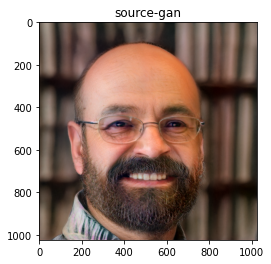

In [ ]:
import cv2
import os
from matplotlib import pyplot as plt

img_gan_source = cv2.imread(os.path.join(OUT,'proj.png'))
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source-gan')
plt.show()

# Build the Video

The following code builds a transition video between the two latent vectors previously obtained.

In [ ]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

STEPS = 150
FPS = 30
FREEZE_STEPS = 30

lvec = [
  np.load('/content/jeff/projected_w.npz')['w'],
  np.load('/content/thor/projected_w.npz')['w']
]

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer('/content/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for i in range(len(lvec)-1):
  lvec1 = lvec[i]
  lvec2 = lvec[i+1]

  diff = lvec2 - lvec1
  step = diff / STEPS
  current = lvec1.copy()

  for j in tqdm(range(STEPS)):
    z = torch.from_numpy(current).to(device)
    synth_image = G.synthesis(z, noise_mode='const')
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

    repeat = FREEZE_STEPS if (j==0 and i==0) or (j==(STEPS-1) and i==(len(lvec)-2)) else 1

    for i in range(repeat):
      video.append_data(synth_image)
    current = current + step


video.close()

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.



# Download your Video

If you made it through all of these steps, you are now ready to download your video.

In [ ]:
from google.colab import files
files.download("movie.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train a GAN from Images

I have an entire notebook for [this](https://github.com/jeffheaton/present/blob/master/youtube/gan/colab_gan_train.ipynb).

# Finetune an Image

If you find a seed that you like, you can fine tune it by adjusting the latent vector directly.  First, choose the seed to finetune.

In [ ]:
START_SEED = 3172

current = seed2vec(G, START_SEED)

Next, generate display the current vector. You will return to this point for each iteration of the finetuning.

In [ ]:
current.shape

(1, 512)

In [ ]:
def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8,
        nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    # [minibatch, height, width, channel]
    images = G.run(z, label, **G_kwargs)
    return images[0]


In [ ]:
# init_random_state(G, 10)
img = generate_image(G, current, 1.0)

SCALE = 0.5
display_image(img, SCALE)

NameError: ignored

Choose an explore size, this is the number of differnt potential images that will be chosen by moving in 10 different directions.  Run this code once initially, and then again anytime you wish to change the 10 directions you are exploring.  You might change the 10 directions if you are no longer seeing improvements.

In [ ]:
EXPLORE_SIZE = 25

explore = []
for i in range(EXPLORE_SIZE):
  explore.append( np.random.rand(1, 512) - 0.5 )

In [ ]:
# Choose the direction to move.  Choose -1 for the initial iteration.
MOVE_DIRECTION = -1
SCALE = 0.5

if MOVE_DIRECTION >=0:
  current = current + explore[MOVE_DIRECTION]

for i, mv in enumerate(explore):
  print(f"Direction {i}")
  init_random_state(Gs, 10)
  z = current + mv
  img = generate_image(Gs, z, 1.0)
  display_image(img, SCALE)